# Import dependencies

In [139]:
from calendar import monthrange
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.cluster import FeatureAgglomeration
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression, mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder

# Load training data frame
Load the data frame for training, which also contains LAID_UP_TIMEs.

In [140]:
df = pd.read_excel("data/Vehicles_export_prices_scaled_train_eng.xlsx")

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99071 entries, 0 to 99070
Columns: 106 entries, RPAKREP_VEHICLE_HKEY to SCALED_TOTAL_SALE_PRICE
dtypes: datetime64[ns](5), float64(42), object(59)
memory usage: 80.1+ MB


In [142]:
df.head()

,RPAKREP_VEHICLE_HKEY,COMPANY,OFFICE,OFFICE_MAIN_BRAND,CHASSIS_NUMBER,MANUFACTURER_SHORT,MANUFACTURER,VEHICLE_GROUP,VEHICLE_TYPE,MODEL_CODE,...,CUSTOMER_SALE_GROUP_NAME,CUSTOMER_SALE_GROUP2,CUSTOMER_SALE_GROUP2_NAME,SCALED_CURRENT_VALUE,SCALED_INVENTURAL_VALUE,SCALED_REPORT_VALUE,SCALED_VALUATION_PRICE,SCALED_GUIDE_PRICE,SCALED_TOTAL_SALES_PRICE_BASIS,SCALED_TOTAL_SALE_PRICE
0,77c1af48604226d47b2ccf7be44df009,44.0,TA,TOY,WF01XXERK1JR43779,FOR,Ford,ECS,ECOSPORT 1.0 Titanium Eco,NaN,...,EV privat,EVPR,Endverbraucher private,0.052907,0.000000,0.950043,0.0,0.002975,0.011018,0.011321
1,39587e4f9324333232d2ffaa2f314e6d,12.0,44,VOL,YV1XZK7V5S2487523,VOL,Volvo,XC4,"XC40 B3 B DKG Core 120 kW, 5-t",536K7170F1,...,NaN,NaN,NaN,0.061605,0.000000,0.950043,0.0,0.006136,0.026411,0.019844
2,a91470879cf756368c1d0099a2fa939a,27.0,33,SKO,WF0DXXSK0RX009819,FOR,Ford,TOC,Tourneo Connect 2.0 EcoBl,26,...,EV privat,EVPR,Endverbraucher private,0.063286,0.000000,0.950043,0.0,0.001378,0.022102,0.022053
3,61363a68ff967e7f0c4b80b46a55b141,33.0,K1,V,WVWZZZAWZPU075160,V,Volkswagen,POL,"POLO LIFE 1,0 L 59 KW (80 PS)",AE13GV,...,Interne Kunden,INT,Interne Kunden,0.042565,0.029537,0.897257,0.0,0.001378,0.000000,0.000572
4,fd5b09f7d857904d03a36d1a479f2ca4,10.0,96,FOR,WF0PXXGCHPRC20073,FOR,Ford,FOC,FOCUS TITA 5W 1.0T 125 MHEV M6,15,...,NaN,NaN,NaN,0.054914,0.000000,0.950043,0.0,0.004863,0.019715,0.013360


# Split train and test set
Split the loaded data frame into a separate train and test data set.

In [143]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

# Data frame preparation
This notebook uses two steps for preprocessing.
One general preparation for data frames and one preprocessing encapsulated in a scikit-learn pipeline.
Everything, what was impossible or too hard to implement in a scikit-learn pipeline, is done in the first preparation.

The following subsections contain the functions for the general preparation.

## Manual dtype correction
We can not be sure that pandas imports the data frame with the correct data types.
Because of that, we specify the data types of each data frame column manually.
We also remove columns, which are obviously not important for the prediction of LAID_UP_TIMEs.

In [144]:
dtypes = {
    "date": "datetime64[ns]",
    "num": np.float64,
    "str": pd.StringDtype(),
}

columns_of_interest = {
    # "RPAKREP_VEHICLE_HKEY": "str", # Some kind of unique car ID
    "COMPANY": "str",
    "OFFICE": "str",
    "OFFICE_MAIN_BRAND": "str",
    "CHASSIS_NUMBER": "str",
    "MANUFACTURER_SHORT": "str",
    "MANUFACTURER": "str",
    "VEHICLE_GROUP": "str",
    "VEHICLE_TYPE": "str",
    "MODEL_CODE": "str",
    "VARIANT": "str",
    "MILEAGE": "num",
    # "OPERATING_HOURS": "num", # Contains mostly 0s (only about 13 rows with other number values)
    # "MILAGE_IN_FIELD": "num", # Contains only 1s
    "MILAGE_SALES": "num",
    # "OPERATING_HOURS_SALES": "num", # Same justification as OPERATING_HOURS
    # "RIM_KEY": "str", # Contains only around 18 rows with non-empty values
    "COLOR_CODE": "str",
    "COLOR_CODE_NAME": "str",
    "COLOR": "str",
    "COLOR_TYPE": "str",
    "UPHOLSTERY_CODE": "str",
    "UPHOLSTERY": "str",
    "UPHOLSTERY_CODE_ALT": "str",
    # "CERTIFICATE_TYPE": "str", # Same justification as OPERATING_HOURS
    # "CERTIFICATE_TYPE_DATE": "num", # Contains only 0s
    "FACTORY_NUMBER": "str",
    "ENGINE_ID": "str",
    "ENGINE_TYPE": "str",
    "ENGINE_ID_ALT": "str",
    "TRANSMISSION": "str",
    "TRANSMISSION_TYPE": "str",
    "TRANSMISSION_ID": "str",
    "TRANSMISSION_SHORT": "str",
    "TRANSMISSION_NAME": "str",
    "RIMS": "str",
    "FRONT_TIRES": "str",
    # "FRONT_TIRES_CONDITION": "num", # Contains only 0s
    "REAR_TIRES": "str",
    # "REAR_TIRES_CONDITION": "num", # Contains only 0s
    "NUMBER_DOORS": "num",
    "NUMBER_SEATS": "num",
    "PERMITTED_TOTAL_WEIGHT": "num",
    "MAX_TRAILOR_LOAD": "num",
    "CURB_WEIGHT": "num",
    "YEAR_CONSTRUCTION": "num",
    "CONSTRUCTION_MONTH": "num",
    "NUMBER_AXLE": "num",
    "NUMBER_ENGINE_CYLINDER": "num",
    # "REPAIR_RKZ": "num", # Contains only 0s
    # "OPTICAL_CONDITION": "num", # Contains only 0s and one row with a 3
    # "TECHNICAL_CONDITION": "num", # Contains only 0s
    "ACCIDENT_VEHICLE": "str",
    # "COMMISSION_NUMBER": "str", # Contains too much unique values
    "HORSEPOWER": "num",
    "KW": "num",
    "CCM": "num",
    "NUMBER_OWNERS": "num",
    "IS_USED_CAR": "num",
    "LEASING_CONTRACT_DATE": "date",
    "LEASING_START": "date",
    "LEASING_END": "date",
    "LEASING_MILAGE": "num",
    # "PAINT_TYPE": "str", # Contains only empty cells
    "FINANCING_TYPE": "str",
    "FINANCING_TYPE_NAME": "str",
    "KAT_VEHICLE": "str",
    "FUEL_TYPE": "str",
    "FUEL_TYPE_NAME": "str",
    "DRIVE_TYPE": "str",
    "DRIVE_TYPE_NAME": "str",
    "VEHICLE_MODEL_ID": "str",
    "VEHICLE_MODEL_ID_NAME": "str",
    "COMMISSION_TYPE": "str",
    "COMMISSION_TYPE_NAME": "str",
    "DEMONSTRATION_STATUS": "str",
    "PURCHASE_DATE": "date",
    "PURCHASE_BOOKING_DATE": "date",
    "PURCHASE_MILAGE": "num",
    # "PURCHASE_OPERATION_HOURS": "num", # Contains only 0s
    "PRICE_LIST": "num",
    # "DAY_OF_REGISTRATION": "str", # Contains only 'N's
    "AT_LOCATION_SINCE": "num",
    "LAID_UP_TIME": "num",
    "SOLD_CUSTOMER_ID": "str",
    "SOLD_INVOICE_COSTUMER_ID": "str",
    "MILAGE_SALE": "num",
    # "OPERATION_HOURS_SALE": "num", # Same justification as OPERATING_HOURS
    # "SOLD_INVOICE_COSTUMER_ID2": "str", # Is nearly identical to SOLD_INVOICE_COSTUMER_ID
    "CUSTOMER_TYPE": "str",
    # "CUSTOMER_GROUP": "str", # Is nearly identical to CUSTOMER_FEATURE
    # "CUSTOMER_GROUP_NAME": "str", # Is nearly identical to CUSTOMER_FEATURE_NAME
    "CUSTOMER_FEATURE": "str",
    "CUSTOMER_FEATURE_NAME": "str",
    # "SALE_CUSTOMER_ID2": "str", # Is nearly identical to SOLD_CUSTOMER_ID
    # "CUSTOMER_SALE_GROUP": "str", # Is nearly identical to CUSTOMER_SALE_GROUP2
    # "CUSTOMER_SALE_GROUP_NAME": "str", # Is nearly identical to CUSTOMER_SALE_GROUP2_NAME (semantically)
    "CUSTOMER_SALE_GROUP2": "str",
    "CUSTOMER_SALE_GROUP2_NAME": "str",
    "SCALED_CURRENT_VALUE": "num",
    "SCALED_INVENTURAL_VALUE": "num",
    "SCALED_REPORT_VALUE": "num",
    # "SCALED_VALUATION_PRICE": "num", # Contains only 0s
    "SCALED_GUIDE_PRICE": "num",
    "SCALED_TOTAL_SALES_PRICE_BASIS": "num",
    "SCALED_TOTAL_SALE_PRICE": "num",
}


def correct_df_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    return df[columns_of_interest.keys()]\
        .astype({k: dtypes[v] for k, v in columns_of_interest.items()})

## Map specific features values
Different values of string (categorical) features are merged together, if they mean the same.

### Merge color values
The COLOR feature contains over 4500 unique values.
Many color values can be merged to a generic color name like 'blue'.
The car color might be very important for the LAID_UP_TIME.
Because of that we try to map the different color names to a limited set of generic color names.

In [145]:
color_mapping = {
    "white": ["WeiÃŸ", "weiß", "weiÃƒ?", "weiss", "white", "bianco", "blanco", "pearl", "snow"],
    "silver": ["silber", "silver", "magnetic sil", "tridion", "hightechsilb"],
    "black": ["schwar", "blac", "obsidian", "nera"],
    "orange": ["orange"],
    "blue": ["blau", "blue", "bleu", "tansanitbl"],
    "red": ["rot", "red", "rosso", "rojo", "tokio fusion", "tokyo fusion", "peperoncino", "bordeaux"],
    "violet": ["violet", "lila", "magenta", "pink"],
    "green": ["grün", "grÃ¼n", "green", "gruen", "gr}n", "camouflage"],
    "yellow": ["gelb", "yellow", "sunflower"],
    "brown": ["braun", "brown", "urban khaki"],
    "bronze": ["bronze"],
    "gold": ["gold", "bright dusk", "platinum quartz"],
    "beige": ["wheat", "beige", "elfenbein", "ivory", "sand"],
    "brass": ["brass", "messing"],
    "grey": ["grau", "gray", "grey", "storm bay", "anthrazit", "thunder", "nero", "granit", "magnetic"],
}


def get_color_mapping(color):
    for k in color_mapping.keys():
        for v in color_mapping[k]:
            if v.lower() in color.lower():
                return k
    return "unknown"

### Merge other features values
The values of other features can also be merged, like 'MERCEDES' and 'MERCEDESBENZ'.
There are also some typos in the values like 'CIRROEN' instead of 'CITROEN' which are also merged.
Some feature values can simply be interpreted as 'not available'.

In [146]:
str_na = pd.NA

MANUFACTURER_mappings = {
    str_na: ["ALLGEMEIN", "ALLGEMEINSONSTIGE", "FABRIKAT", "FREMDFABRIKAT", "FREMDTEILENURFÃ¼RTEILE", "FREMDTEILFREMDFABRIKAT", "MUSSZUGETEILTWERDEN"],
    "CITROEN": ["CIRROEN", "CITROÃªN"],
    "MERCEDES": ["MERCEDESBENZ"],
    "VW": ["VOLKSWAGEN"],
}

COLOR_CODE_NAME_mappings = {
    str_na: ["NICHTDEFINIERT"]
}

ENGINE_TYPE_mappings = {
    str_na: ["BITTEMOTIDPFLEGEN"]
}

TRANSMISSION_NAME_mappings = {
    str_na: ["NICHTDEFINIERT"]
}

FINANCING_TYPE_NAME_mappings = {
    str_na: ["NICHTDEFINIERT"]
}

FUEL_TYPE_NAME_mappings = {
    str_na: ["ANDERE"]
}

DRIVE_TYPE_NAME_mappings = {
    str_na: ["NICHTDEFINIERT", "ANDERE"]
}

VEHICLE_MODEL_ID_NAME_mappings = {
    str_na: ["KEINEZUTEILUNG"]
}

generic_code_mappings = {
    str_na: ["N"]
}


def map_to_nan(feature: pd.DataFrame, values: list) -> pd.DataFrame:
    return feature.map(lambda x: np.nan if x in values else x)


def normalize_str_column(feature: pd.DataFrame) -> pd.DataFrame:
    return feature\
        .map(lambda x: pd.NA if type(x) != str else remove_special_characters(x.upper()))\
        .map(lambda x: pd.NA if type(x) != str or not x else x)\
        .astype(dtypes["str"])


def remove_special_characters(s: str) -> str:
    return "".join(filter(str.isalnum, s))


def map_str_column(feature: pd.DataFrame, mappings: object) -> pd.DataFrame:
    return feature.map(lambda x: pd.NA if type(x) != str else map_str(x, mappings)).astype(dtypes["str"])


def map_str(s: str, mappings: object) -> str:
    if not s:
        return str_na
    for key in mappings:
        if s in mappings[key]:
            return key
    return s


def map_specific_feature_values(df: pd.DataFrame) -> pd.DataFrame:
    df_map = df.copy()

    # Date features
    df_map["LEASING_CONTRACT_DATE"] = df_map["LEASING_CONTRACT_DATE"].map(lambda x: pd.NaT if x.year > 2050 else x)
    df_map["LEASING_END"] = df_map["LEASING_END"].map(lambda x: pd.NaT if x.year > 2050 else x)

    # Num features
    df_map["PERMITTED_TOTAL_WEIGHT"] = map_to_nan(df_map["PERMITTED_TOTAL_WEIGHT"], [0.0])
    df_map["CURB_WEIGHT"] = map_to_nan(df_map["CURB_WEIGHT"], [0.0])
    df_map["HORSEPOWER"] = map_to_nan(df_map["HORSEPOWER"], [0.0])
    df_map["KW"] = map_to_nan(df_map["KW"], [0.0])
    df_map["CCM"] = map_to_nan(df_map["CCM"], [0.0])
    df_map["SCALED_INVENTURAL_VALUE"] = map_to_nan(df_map["SCALED_INVENTURAL_VALUE"], [0.0])
    df_map["YEAR_CONSTRUCTION"] = df_map["YEAR_CONSTRUCTION"].map(lambda x: np.nan if x < 1900 else x)

    # Str features
    df_map["MANUFACTURER_SHORT"] = normalize_str_column(df_map["MANUFACTURER_SHORT"])
    df_map["MANUFACTURER"] = map_str_column(normalize_str_column(df_map["MANUFACTURER"]), MANUFACTURER_mappings)
    df_map["VEHICLE_GROUP"] = normalize_str_column(df_map["VEHICLE_GROUP"])
    df_map["VEHICLE_TYPE"] = normalize_str_column(df_map["VEHICLE_TYPE"])
    df_map["MODEL_CODE"] = normalize_str_column(df_map["MODEL_CODE"])
    df_map["COLOR_CODE_NAME"] = map_str_column(normalize_str_column(df_map["COLOR_CODE_NAME"]), COLOR_CODE_NAME_mappings)
    df_map["COLOR"] = normalize_str_column(df_map["COLOR"])
    df_map["COLOR_TYPE"] = map_str_column(df_map["COLOR_TYPE"], generic_code_mappings)
    df_map["UPHOLSTERY"] = normalize_str_column(df_map["UPHOLSTERY"])
    df_map["UPHOLSTERY_CODE_ALT"] = map_str_column(df_map["UPHOLSTERY_CODE_ALT"], generic_code_mappings)
    df_map["FACTORY_NUMBER"] = normalize_str_column(df_map["FACTORY_NUMBER"])
    df_map["ENGINE_TYPE"] = map_str_column(normalize_str_column(df_map["ENGINE_TYPE"]), ENGINE_TYPE_mappings)
    df_map["ENGINE_ID_ALT"] = normalize_str_column(df_map["ENGINE_ID_ALT"])
    df_map["TRANSMISSION_TYPE"] = normalize_str_column(df_map["TRANSMISSION_TYPE"])
    df_map["TRANSMISSION_ID"] = normalize_str_column(df_map["TRANSMISSION_ID"])
    df_map["TRANSMISSION_NAME"] = map_str_column(normalize_str_column(df_map["TRANSMISSION_NAME"]), TRANSMISSION_NAME_mappings)
    df_map["ACCIDENT_VEHICLE"] = map_str_column(df_map["ACCIDENT_VEHICLE"], generic_code_mappings)
    df_map["FINANCING_TYPE"] = map_str_column(df_map["FINANCING_TYPE"], generic_code_mappings)
    df_map["FINANCING_TYPE_NAME"] = map_str_column(normalize_str_column(df_map["FINANCING_TYPE_NAME"]), FINANCING_TYPE_NAME_mappings)
    df_map["KAT_VEHICLE"] = map_str_column(df_map["KAT_VEHICLE"], generic_code_mappings)
    df_map["FUEL_TYPE"] = map_str_column(df_map["FUEL_TYPE"], generic_code_mappings)
    df_map["FUEL_TYPE_NAME"] = map_str_column(normalize_str_column(df_map["FUEL_TYPE_NAME"]), FUEL_TYPE_NAME_mappings)
    df_map["DRIVE_TYPE"] = map_str_column(df_map["DRIVE_TYPE"], generic_code_mappings)
    df_map["DRIVE_TYPE_NAME"] = map_str_column(normalize_str_column(df_map["DRIVE_TYPE_NAME"]), DRIVE_TYPE_NAME_mappings)
    df_map["VEHICLE_MODEL_ID_NAME"] = map_str_column(normalize_str_column(df_map["VEHICLE_MODEL_ID_NAME"]), VEHICLE_MODEL_ID_NAME_mappings)
    df_map["CUSTOMER_FEATURE_NAME"] = normalize_str_column(df_map["CUSTOMER_FEATURE_NAME"])
    df_map["CUSTOMER_SALE_GROUP2_NAME"] = normalize_str_column(df_map["CUSTOMER_SALE_GROUP2_NAME"])

    # Map colors to either a base color or pd.NA
    df_map["COLOR"] = df_map["COLOR"]\
        .map(lambda x: pd.NA if type(x) != str else get_color_mapping(x))\
        .map(lambda x: pd.NA if type(x) != str or x == "unknown" else x)\
        .astype(dtypes["str"])

    return df_map

## Add custom features
We construct some custom features from other ones.

In [147]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]


def create_date(year, month=1, day=1):
    if math.isnan(year) or math.isnan(month) or math.isnan(day):
        return pd.NaT
    if year < 1900:
        return pd.NaT
    return datetime.datetime(int(year), int(month), int(day))


def month_idx_to_name(month_idx):
    if math.isnan(month_idx):
        return pd.NA
    return months[int(month_idx - 1)]


def day_idx_to_name(day_idx):
    if math.isnan(day_idx):
        return pd.NA
    return int(day_idx)


def weekday_idx_to_name(weekday_idx):
    if math.isnan(weekday_idx):
        return pd.NA
    return days[int(weekday_idx)]


def add_custom_features(df: pd.DataFrame) -> pd.DataFrame:
    df_feat = df.copy()
    
    # Compare OFFICE_MAIN_BRAND and MANUFACTURER_SHORT (create binary feature)
    df_feat["COMP__OFFICE_MAIN_BRAND__MANUFACTURER_SHORT"] = \
        (df_feat["OFFICE_MAIN_BRAND"] == df_feat["MANUFACTURER_SHORT"])\
        .astype(dtypes["num"])
    
    # Compare SOLD_CUSTOMER_ID and SOLD_INVOICE_COSTUMER_ID (create binary feature)
    df_feat["COMP__SOLD_CUSTOMER_ID__SOLD_INVOICE_COSTUMER_ID"] = \
        (df_feat["SOLD_CUSTOMER_ID"] == df_feat["SOLD_INVOICE_COSTUMER_ID"])\
        .astype(dtypes["num"])
    
    # Compare CUSTOMER_FEATURE and CUSTOMER_SALE_GROUP2 (create binary feature)
    df_feat["COMP__CUSTOMER_FEATURE__CUSTOMER_SALE_GROUP2"] = \
        (df_feat["CUSTOMER_FEATURE"] == df_feat["CUSTOMER_SALE_GROUP2"])\
        .astype(dtypes["num"])

    # Construct datetime from YEAR_CONSTRUCTION and CONSTRUCTION_MONTH
    df_feat["CONSTRUCTION_DATE"] = df_feat[["YEAR_CONSTRUCTION", "CONSTRUCTION_MONTH"]]\
        .apply(lambda x: create_date(year=x["YEAR_CONSTRUCTION"], month=x["CONSTRUCTION_MONTH"]), axis=1)\
        .astype(dtypes["date"])

    # Separate year, month, day, weekday for date features
    for col in df_feat.select_dtypes(include=dtypes["date"]).columns:
        df_feat[f"{col}__YEAR"] = df_feat[col].map(lambda date: date.year)\
            .astype(dtypes["num"])

        df_feat[f"{col}__MONTH"] = df_feat[col].map(lambda date: month_idx_to_name(date.month))\
            .astype(dtypes["str"])

        df_feat[f"{col}__DAY"] = df_feat[col].map(lambda date: day_idx_to_name(date.day))\
            .astype(dtypes["str"])
        
        df_feat[f"{col}__WEEKDAY"] = df_feat[col].map(lambda date: weekday_idx_to_name(date.weekday()))\
            .astype(dtypes["str"])
    
    # Create features from time spans between different date features
    date_cols = df_feat.select_dtypes(include=dtypes["date"]).columns
    for date_col_idx_a in range(len(date_cols)):
        for date_col_idx_b in range(date_col_idx_a + 1, len(date_cols)):
            date_col_a = date_cols[date_col_idx_a]
            date_col_b = date_cols[date_col_idx_b]
            df_feat[f"DIFF__{date_col_a}__{date_col_b}"] = \
                (df_feat[date_col_a] - df_feat[date_col_b])\
                .map(lambda diff: diff.days)\
                .astype(dtypes["num"])
    
    return df_feat

## Percentile clamping
Some numeric features contain outliers.
To remove them we compute the 1-percentile and 99-percentile for every numeric feature and clamp the feature values in that range.

In [148]:
cols_to_ignore = [
    "LAID_UP_TIME"
]

# List to save the computed percentiles
perc_qs = []


def clamp_percentiles(df: pd.DataFrame, fit: bool) -> pd.DataFrame:
    df_perc = df.copy()

    if fit:
        perc_qs.clear()

    for col in df_perc.select_dtypes(include=dtypes["num"]).columns:
        # Ignore features which contain integers (none continuous numeric features)
        if len(df_perc[col].unique()) < 50:
            continue
        if col in cols_to_ignore:
            continue

        # 'scaled' features should be in the range [0, 1]
        if col.startswith("SCALED_"):
            df_perc[col] = df_perc[col].map(lambda x: 0.0 if x < 0.0 else (1.0 if x > 1.0 else x))
            continue
        
        q_low = 0.0
        q_high = 0.0
        if fit:
            q_low = df_perc[col].quantile(0.01)
            q_high = df_perc[col].quantile(0.99)
            perc_qs.append([col, q_low, q_high])
        else:
            perc_q = next(x for x in perc_qs if x[0] == col)
            q_low = perc_q[1]
            q_high = perc_q[2]

        df_perc[col] = df_perc[col].map(lambda x: q_low if x < q_low else (q_high if x > q_high else x))
    return df_perc

## Preparation function
The final function for general data frame preparation.

In [149]:
def filter_non_num_values(feature: pd.DataFrame) -> pd.DataFrame:
    return feature.map(lambda x: x if type(x) == float or type(x) == int else np.nan)


def prepare_data_frame(df: pd.DataFrame, is_test: bool, drop_rows: bool) -> pd.DataFrame:
    df_prep = df.copy()

    # YEAR_CONSTRUCTION Fix
    df_prep["YEAR_CONSTRUCTION"] = filter_non_num_values(df_prep["YEAR_CONSTRUCTION"])

    # PRICE_LIST Fix
    df_prep["PRICE_LIST"] = filter_non_num_values(df_prep["PRICE_LIST"])
    
    # Manual dtype correction
    df_prep = correct_df_dtypes(df_prep)

    # Keep only unique rows
    if drop_rows:
        df_prep = df_prep.drop_duplicates()

    # Map specific feature values
    df_prep = map_specific_feature_values(df_prep)
    
    # Add custom features
    df_prep = add_custom_features(df_prep)

    # Percentile filtering
    df_prep = clamp_percentiles(df_prep, not is_test)
    
    if drop_rows:
        # Clamp LAID_UP_TIMEs, which are to high
        if not is_test:
            df_prep["LAID_UP_TIME"] = df_prep["LAID_UP_TIME"].map(lambda x: 3000 if x > 3000 else x)
    
        # Drop train samples without label value
        df_prep = df_prep.dropna(subset=["LAID_UP_TIME"])

    return df_prep

## Prepare loaded data frame
The training data frame and the test data frame are prepared with the previous steps.

In [151]:
df_train_prep = prepare_data_frame(df_train, is_test=False, drop_rows=True)
df_test_prep = prepare_data_frame(df_test, is_test=True, drop_rows=True)

In [152]:
df_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79080 entries, 11190 to 68268
Columns: 125 entries, COMPANY to DIFF__PURCHASE_BOOKING_DATE__CONSTRUCTION_DATE
dtypes: datetime64[ns](6), float64(52), string(67)
memory usage: 76.0 MB


In [153]:
df_train_prep.head()

,COMPANY,OFFICE,OFFICE_MAIN_BRAND,CHASSIS_NUMBER,MANUFACTURER_SHORT,MANUFACTURER,VEHICLE_GROUP,VEHICLE_TYPE,MODEL_CODE,VARIANT,...,DIFF__LEASING_START__LEASING_END,DIFF__LEASING_START__PURCHASE_DATE,DIFF__LEASING_START__PURCHASE_BOOKING_DATE,DIFF__LEASING_START__CONSTRUCTION_DATE,DIFF__LEASING_END__PURCHASE_DATE,DIFF__LEASING_END__PURCHASE_BOOKING_DATE,DIFF__LEASING_END__CONSTRUCTION_DATE,DIFF__PURCHASE_DATE__PURCHASE_BOOKING_DATE,DIFF__PURCHASE_DATE__CONSTRUCTION_DATE,DIFF__PURCHASE_BOOKING_DATE__CONSTRUCTION_DATE
11190,24.0,54,BMW,WBAXX510900P97299,BMW,BMW,F26,X4XDRIVE35D,XX51,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2747.0,2747.0
58518,12.0,46,FOR,WF0FXXWPCFKD65172,FOR,FORD,MON,MONDEOTURNIER20ECOBLU,40,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1901.0,1901.0
20033,44.0,T4,TOY,YBCDB41080W029477,TOY,TOYOTA,45,SUPRAGR30AUTOMATIK,DB41LZRLW,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1468.0,1468.0
27808,18.0,67,FOR,6FPPXXMJ2PKK79983,FOR,FORD,RAN,RANGERAUTMWILDTRAK,67,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-88.0,1868.0,1956.0
32523,44.0,T2,TOY,JTDKBABB60A382424,TOY,TOYOTA,8,YARISCROSS15L4X2HYBRI,MXPJ10LBHXNBW,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,50.0,50.0


# Inspect features
Inspect the features of the prepared data frame.

## Inspect the distribution of numeric features

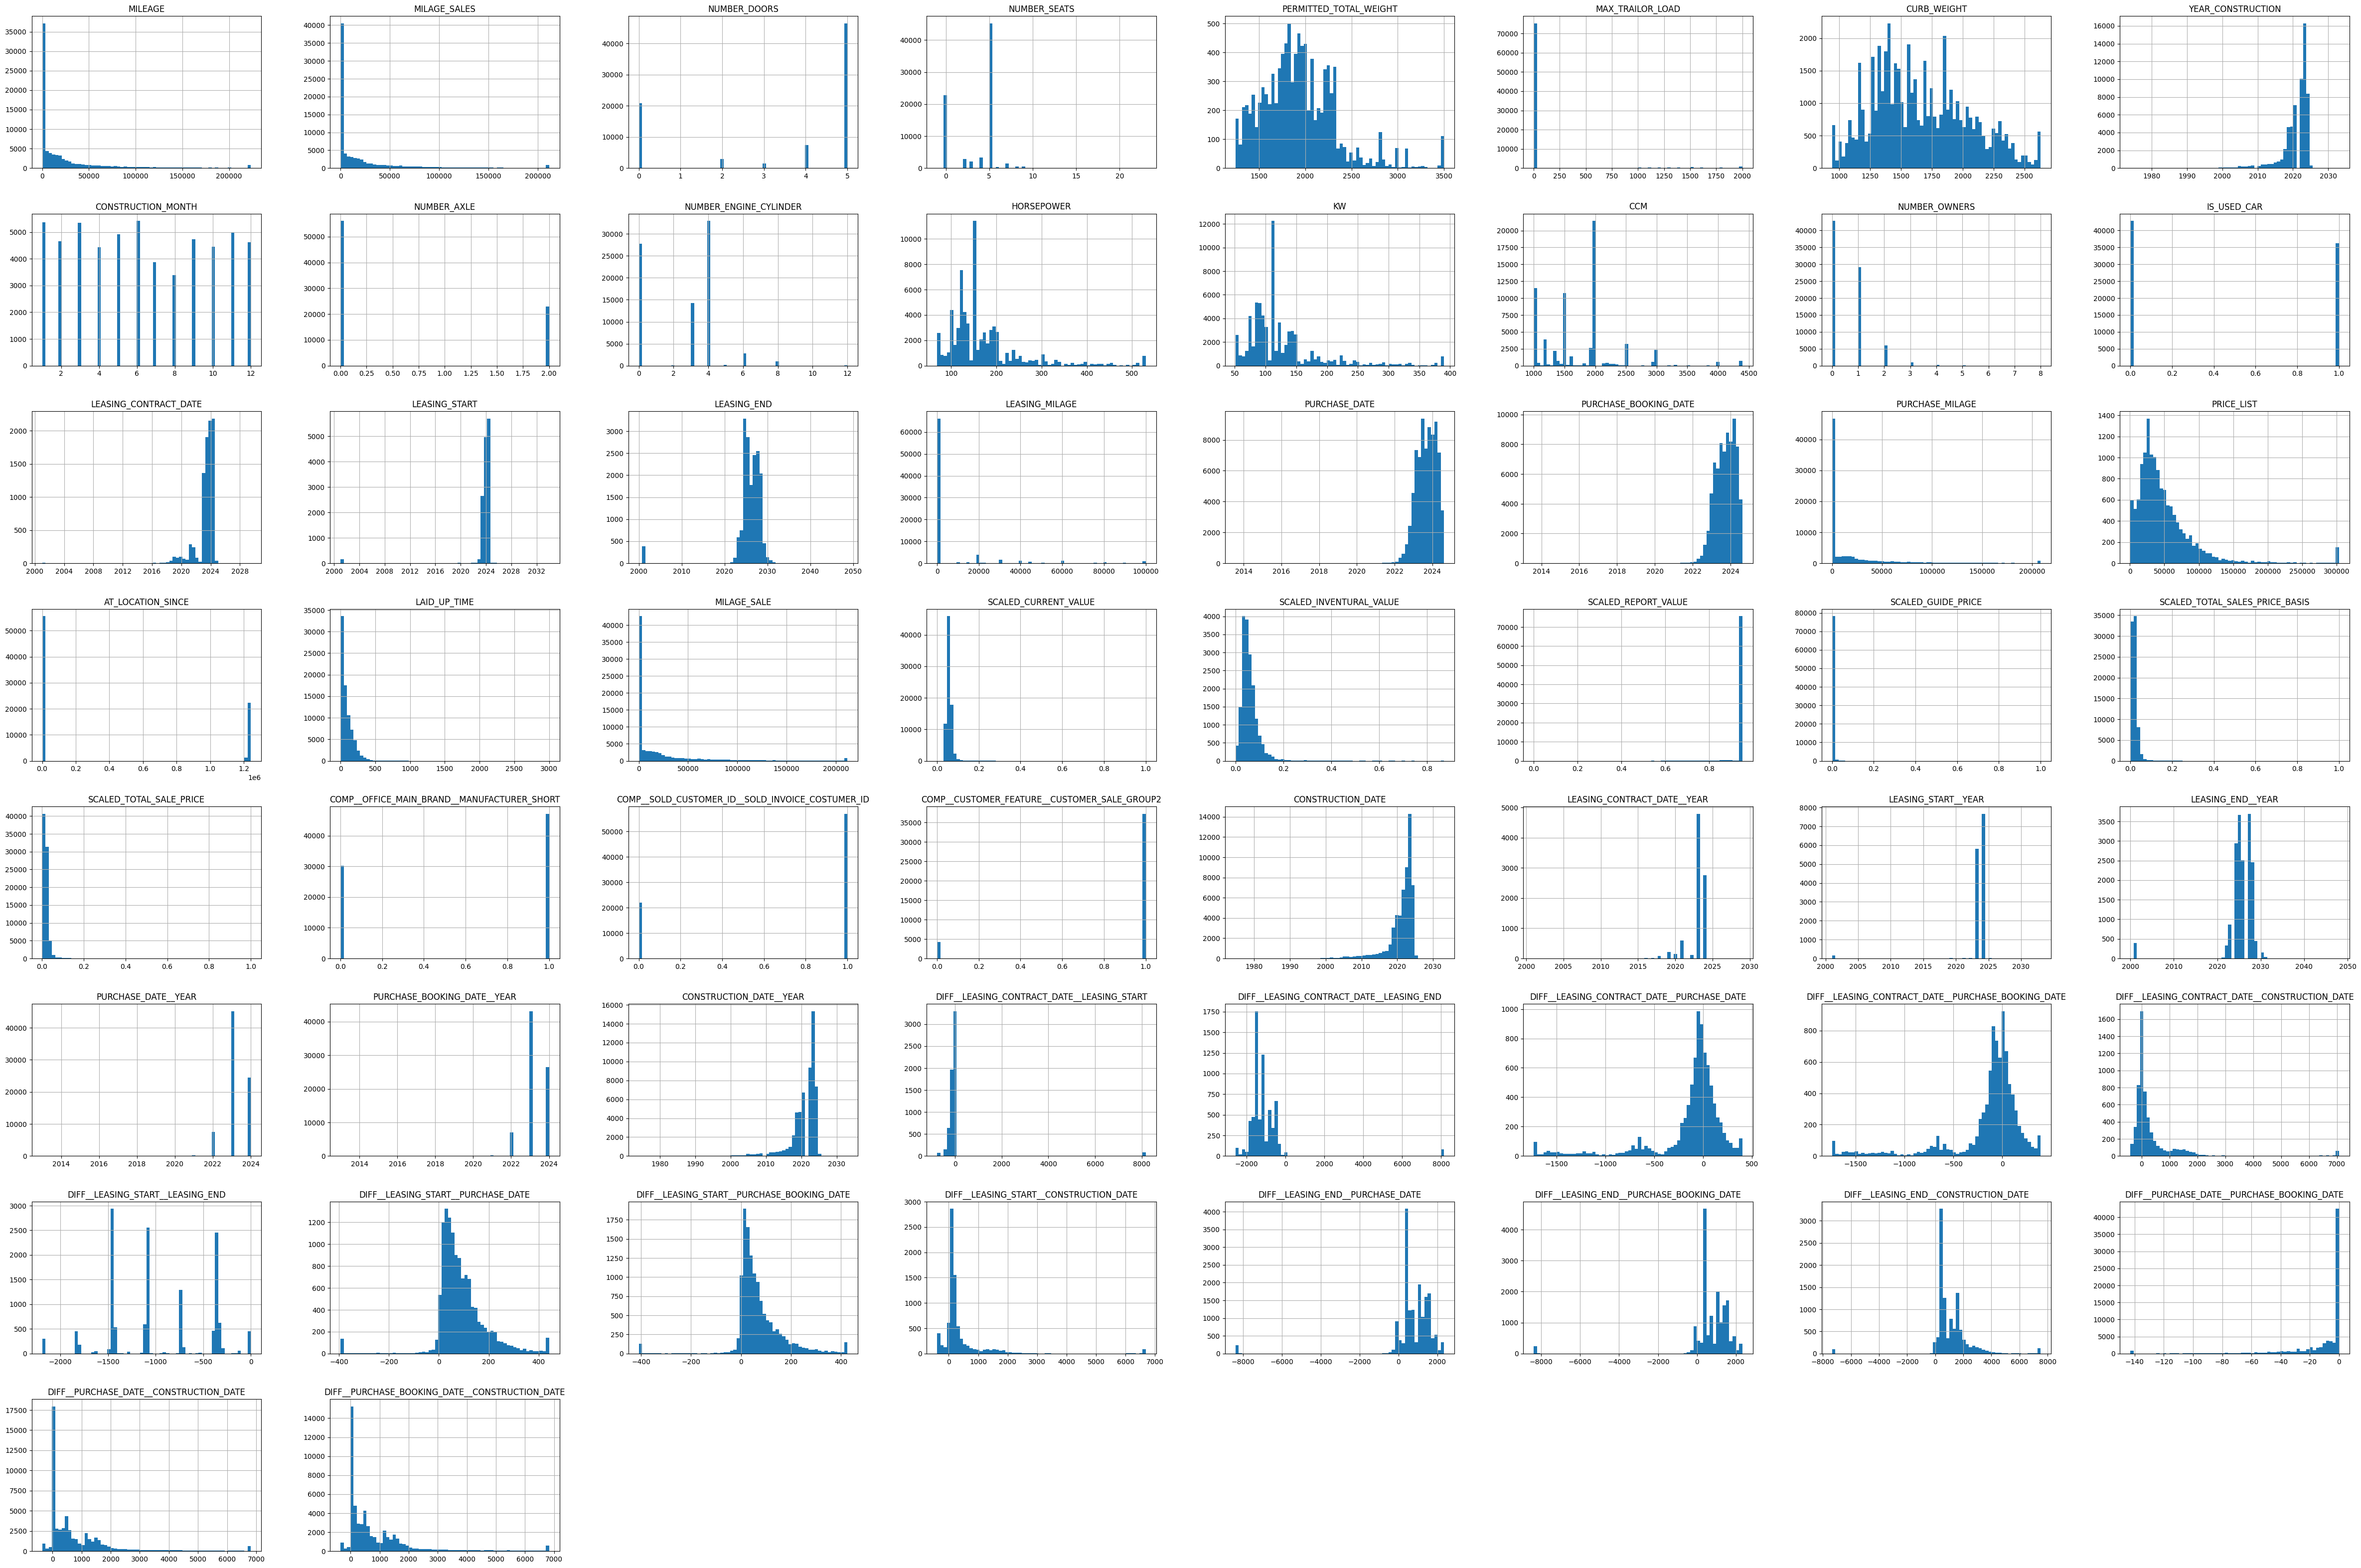

In [154]:
df_train_prep.hist(bins=64, figsize=(60, 40))
plt.show()

## Inspect numeric feature correlation

In [155]:
corr_matrix = df_train_prep.select_dtypes(include=dtypes["num"]).corr()
print(corr_matrix["LAID_UP_TIME"][corr_matrix["LAID_UP_TIME"].notna()].sort_values(ascending=False))

LAID_UP_TIME                                          1.000000
DIFF__LEASING_START__PURCHASE_DATE                    0.709864
DIFF__LEASING_START__PURCHASE_BOOKING_DATE            0.601654
DIFF__LEASING_CONTRACT_DATE__PURCHASE_DATE            0.164223
DIFF__LEASING_CONTRACT_DATE__PURCHASE_BOOKING_DATE    0.156077
DIFF__LEASING_END__PURCHASE_DATE                      0.138521
DIFF__LEASING_END__PURCHASE_BOOKING_DATE              0.128252
CONSTRUCTION_DATE__YEAR                               0.115616
YEAR_CONSTRUCTION                                     0.100359
LEASING_END__YEAR                                     0.098522
AT_LOCATION_SINCE                                     0.096517
DIFF__LEASING_START__LEASING_END                      0.096403
LEASING_START__YEAR                                   0.093664
NUMBER_AXLE                                           0.066776
COMP__SOLD_CUSTOMER_ID__SOLD_INVOICE_COSTUMER_ID      0.053607
IS_USED_CAR                                           0

# Split features and labels
Split the data frames into features and labels.

In [156]:
def split_data_frame(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    # Features
    X = df.drop("LAID_UP_TIME", axis=1)

    # Labels
    y = df["LAID_UP_TIME"]

    return X, y

In [54]:
X_train, y_train = split_data_frame(df_train_prep)
X_test, y_test = split_data_frame(df_test_prep)

## Inspect distribution of LAID_UP_TIME

mean: 88.33501517450682
std: 95.79825142064274


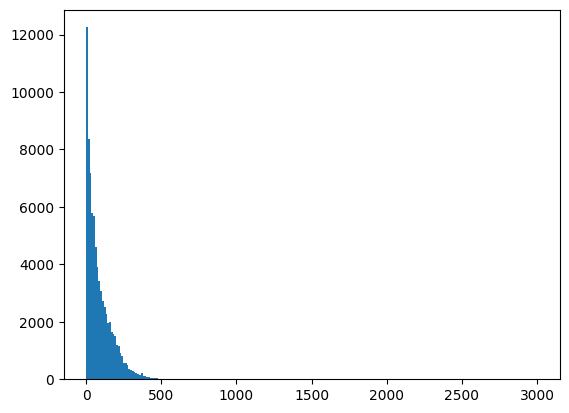

In [157]:
print(f"mean: {np.mean(y_train)}")
print(f"std: {np.std(y_train)}")
plt.hist(y_train, bins=256)
plt.show()

# Preprocessing
This section contains the second preprocessing encapsulated in a scikit-learn pipeline.

## Pipeline creation
The function `create_preprocessor` create the preprocessing pipeline.

In [158]:
def map_date(feature: pd.DataFrame) -> pd.DataFrame:
    return feature.map(lambda date: date_to_number(date))


def date_to_number(date: np.datetime64) -> np.float64:
    if date is pd.NaT:
        return np.nan
    return date.year + date.month / 12.0 + date.day / (12.0 * monthrange(date.year, date.month)[1])


def create_preprocessor(
    keep_dates: bool = True,
    keep_nums: bool = True,
    keep_strs: bool = True,
    encoding: str = "one_hot",
    use_feat_aggl: bool = True,
) -> Pipeline:
    # Preprocessing of date features
    date_transformer = Pipeline([
        ("converter", FunctionTransformer(map_date)),
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
    ])

    # Preprocessing of numeric features
    num_transformer = Pipeline([
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
    ])

    # Preprocessing of string (categorical) features
    str_transformers = [
        ("imputer", SimpleImputer(missing_values=pd.NA, strategy="constant", keep_empty_features=True, fill_value="N/A")),
    ]
    if encoding == "one_hot":
        str_transformers.append(("encoder", OneHotEncoder(min_frequency=0.05, handle_unknown="infrequent_if_exist", sparse_output=False)))
    elif encoding == "ordinal":
        str_transformers.append(("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)))
    else:
        raise Exception("unsupported encoding")
    str_transformer = Pipeline(str_transformers)

    # Column transformer for the different feature data types
    per_dtype_transformers = []
    if keep_dates:
        per_dtype_transformers.append(\
            ("date", date_transformer, make_column_selector(dtype_include=dtypes["date"])))
    if keep_nums:
        per_dtype_transformers.append(\
            ("num", num_transformer, make_column_selector(dtype_include=dtypes["num"])))
    if keep_strs:
        per_dtype_transformers.append(\
            ("str", str_transformer, make_column_selector(dtype_include=dtypes["str"])))
    
    # Construction of the final pipeline
    final_pipeline_transformers = [
        ("per_dtype", ColumnTransformer(per_dtype_transformers)),
        ("variance_threshold", VarianceThreshold()),
    ]
    if use_feat_aggl:
        final_pipeline_transformers.append(\
            ("feature_agglomeration", FeatureAgglomeration(n_clusters=None, compute_full_tree=True, distance_threshold=10.0)))

    return Pipeline(final_pipeline_transformers)

## Inspect preprocessing pipeline
Draw the preprocessing pipeline as a graph.

In [159]:
create_preprocessor()

Pipeline(steps=[('per_dtype',
                 ColumnTransformer(transformers=[('date',
                                                  Pipeline(steps=[('converter',
                                                                   FunctionTransformer(func=<function map_date at 0x7f96c2eee7a0>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f96c3338fd0>),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleIm...
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05,
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9593023fd0>)])),
                ('variance_threshold', VarianceThreshold()),
                ('feature_agglomeration',
                 FeatureAgglomeration(compute_full_tree=True,
                                      distance_threshold=10.0,
                                      n_clusters=None))])

## Visualize the preprocessed numerical features

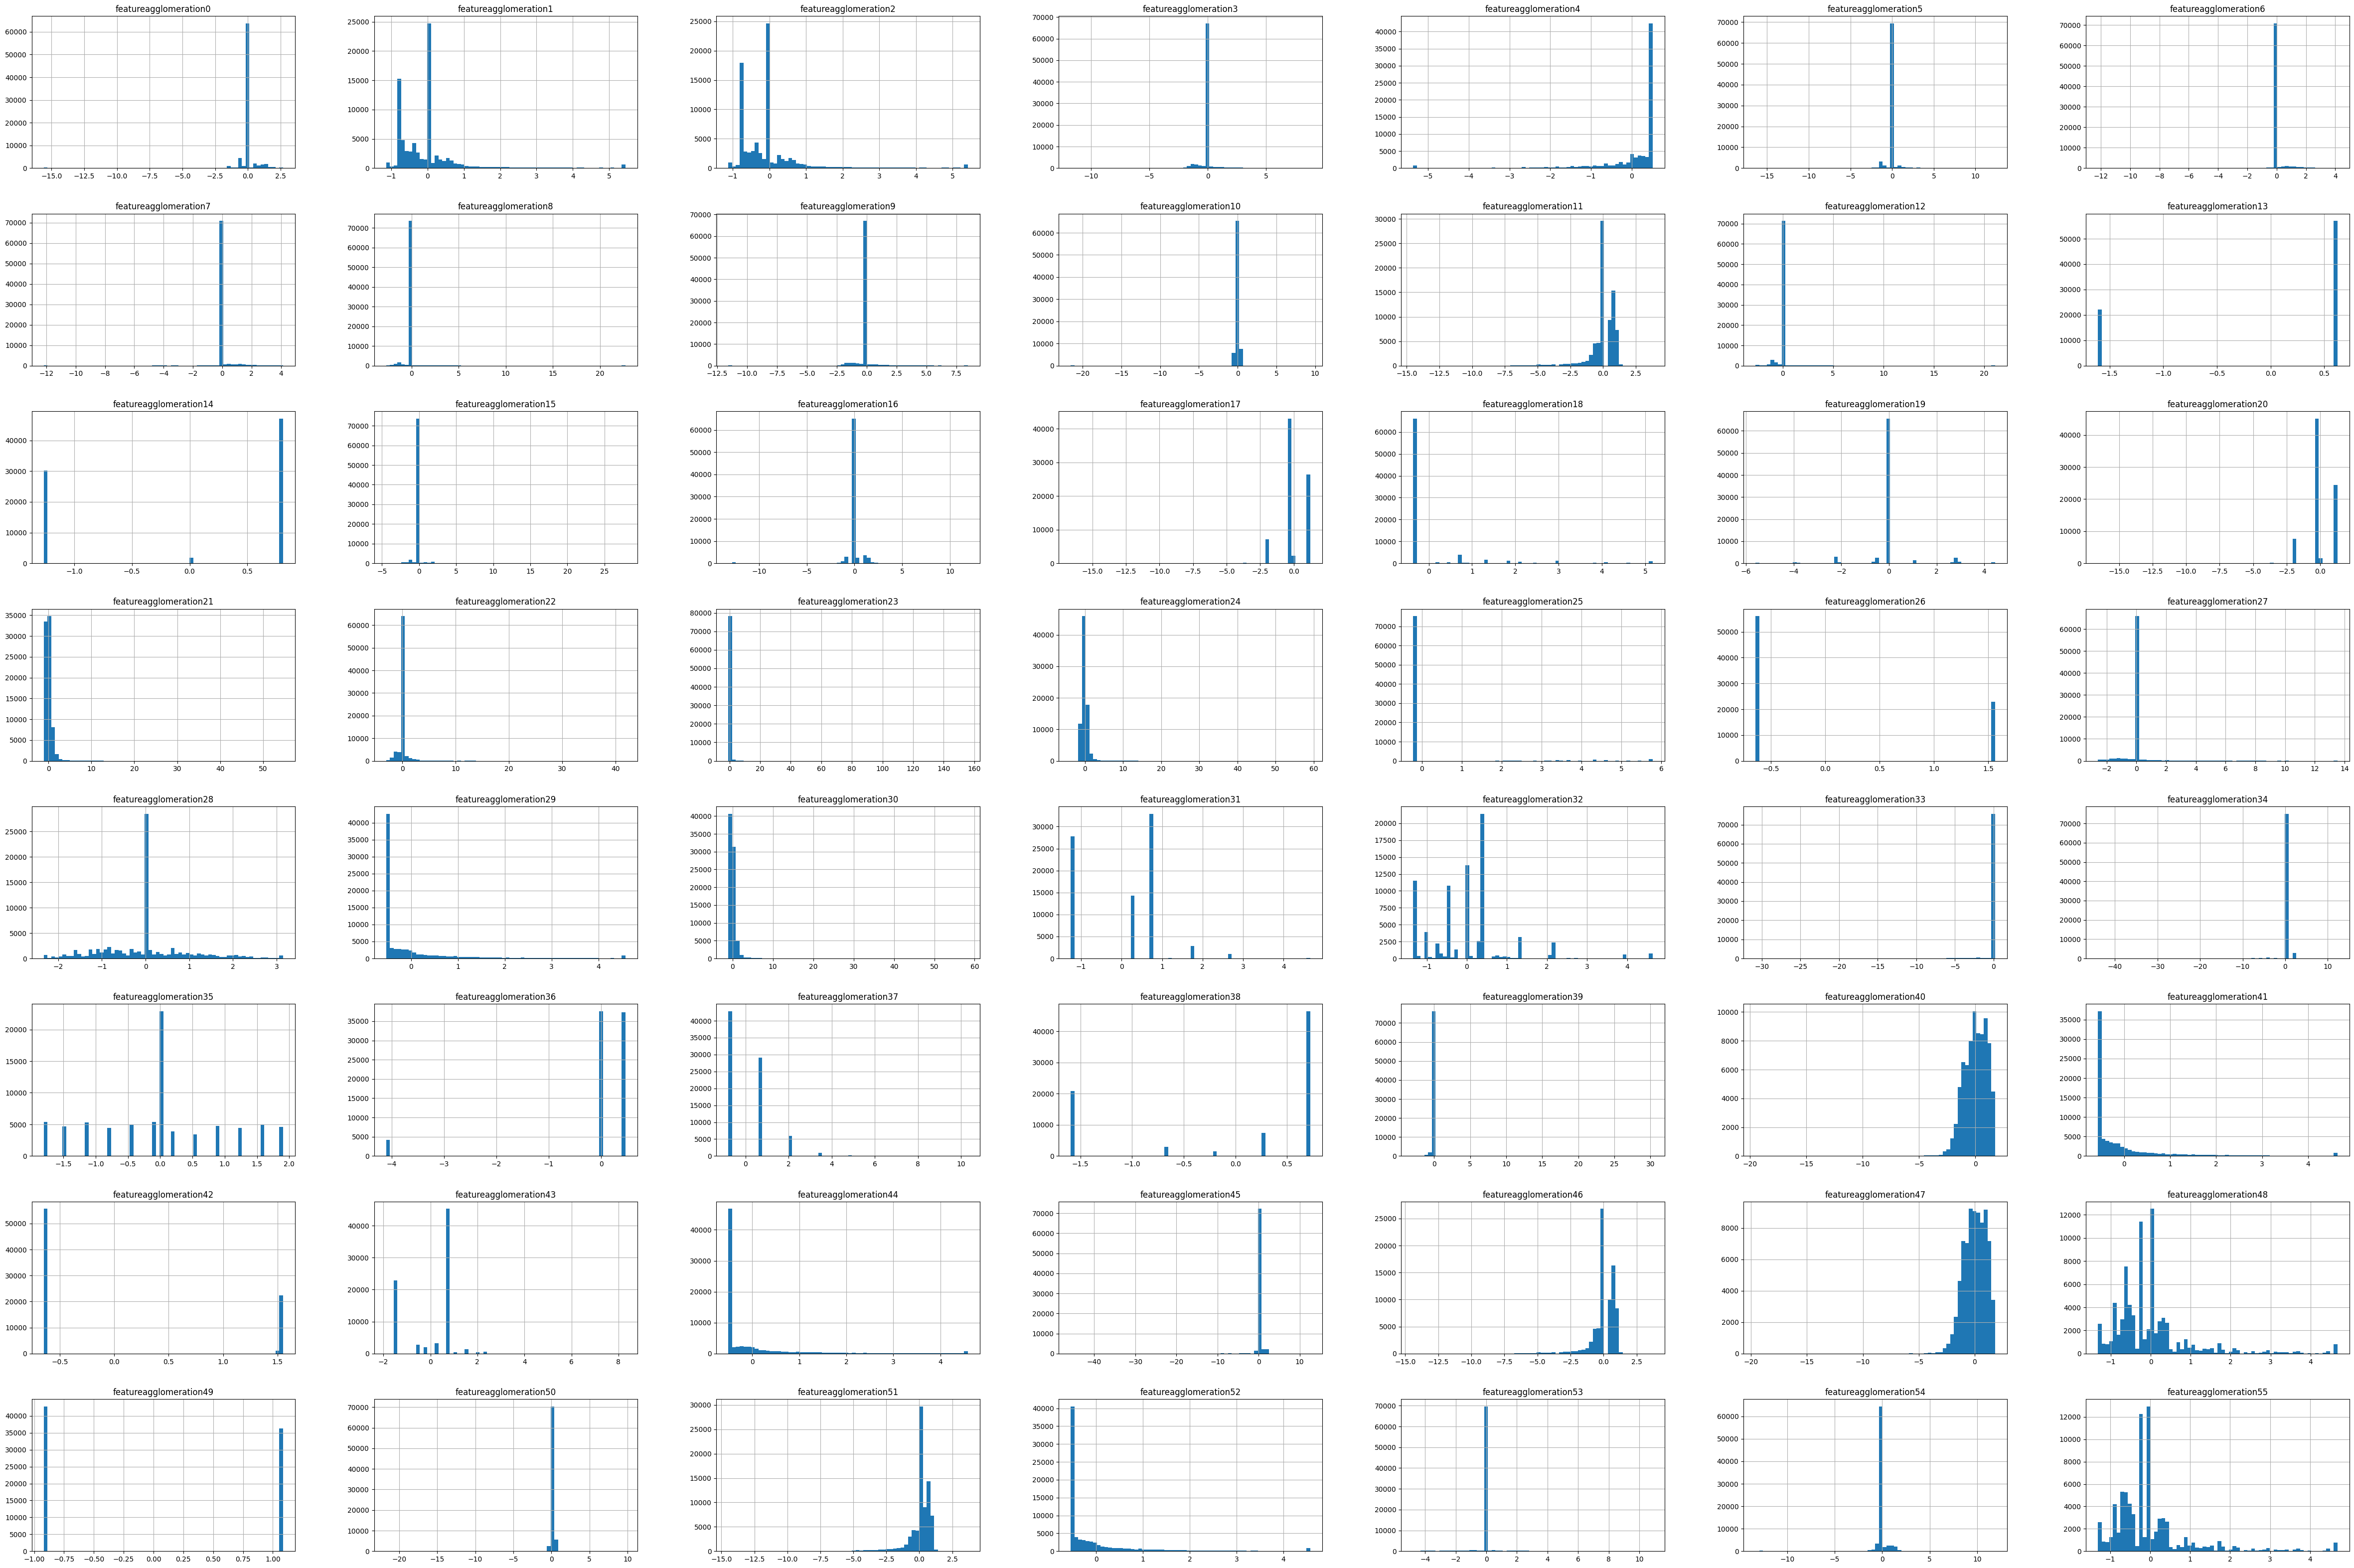

In [160]:
preprocessor = create_preprocessor(keep_strs=False)
preprocessor.set_output(transform="pandas")
X_train_prep: pd.DataFrame = preprocessor.fit_transform(X_train, y_train)
X_train_prep.hist(bins=64, figsize=(60, 40))
plt.show()

## Look into the number of features after preprocessing and encoding

In [161]:
preprocessor = create_preprocessor()
preprocessor.set_output(transform="pandas")
X_train_prep: pd.DataFrame = preprocessor.fit_transform(X_train, y_train)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79080 entries, 11190 to 68268
Columns: 250 entries, featureagglomeration0 to featureagglomeration249
dtypes: float64(250)
memory usage: 151.4 MB


## Get the mapping of original features for feature agglomeration

In [162]:
preprocessor_no_feat_aggl = create_preprocessor(use_feat_aggl=False)
preprocessor_no_feat_aggl.set_output(transform="pandas")
X_train_prep_no_feat_aggl: pd.DataFrame = preprocessor_no_feat_aggl.fit_transform(X_train, y_train)

for agg_idx in range(preprocessor["feature_agglomeration"].n_clusters_):
    line = f"{agg_idx}: "
    for col in X_train_prep_no_feat_aggl.columns[preprocessor["feature_agglomeration"].labels_ == agg_idx]:
        line += f"{col}, "
    print(line)

0: str__MANUFACTURER_SHORT_infrequent_sklearn, str__MANUFACTURER_infrequent_sklearn, 
1: str__MANUFACTURER_SHORT_WDB, str__MANUFACTURER_MERCEDES, 
2: num__DIFF__LEASING_END__PURCHASE_DATE, num__DIFF__LEASING_END__PURCHASE_BOOKING_DATE, 
3: str__LEASING_END__MONTH_N/A, str__LEASING_END__DAY_N/A, str__LEASING_END__WEEKDAY_N/A, 
4: str__MANUFACTURER_SHORT_V, str__MANUFACTURER_VW, 
5: str__CUSTOMER_SALE_GROUP2_N/A, str__CUSTOMER_SALE_GROUP2_NAME_N/A, 
6: str__COMPANY_33.0, str__OFFICE_MAIN_BRAND_V, 
7: str__LEASING_CONTRACT_DATE__MONTH_N/A, str__LEASING_CONTRACT_DATE__DAY_N/A, str__LEASING_CONTRACT_DATE__WEEKDAY_N/A, 
8: str__VEHICLE_MODEL_ID_1.0, str__VEHICLE_MODEL_ID_NAME_LIMOUSINE, 
9: str__VEHICLE_MODEL_ID_0.0, str__VEHICLE_MODEL_ID_NAME_N/A, 
10: str__CUSTOMER_TYPE_N/A, str__CUSTOMER_FEATURE_N/A, str__CUSTOMER_FEATURE_NAME_N/A, 
11: str__CUSTOMER_FEATURE_infrequent_sklearn, str__CUSTOMER_FEATURE_NAME_infrequent_sklearn, 
12: str__FUEL_TYPE_infrequent_sklearn, str__FUEL_TYPE_NAME_infre

# Model selection (training)
This section contains the training and tuning of different models.

## Helper functions

In [163]:
# Validates a model with a simple train/validate split.
def validate_model(model: BaseEstimator):
    X_val_train, X_val, y_val_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=12) 
    model.fit(X_val_train, y_val_train)
    y_pred = model.predict(X_val)
    print("RMSE:", root_mean_squared_error(y_val, y_pred))

In [164]:
# Validates a model with 5-fold cross validation.
def cross_validate_model(model: BaseEstimator):
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print("RMSE Scores:", rmse_scores)
    print("RMSE Mean:", rmse_scores.mean())
    print("RMSE Std:", rmse_scores.std())

In [165]:
# Execute grid search with cross validation for a model and a given set of parameter combinations.
def hyper_param_tune_model(model: BaseEstimator, param_grid):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",
        cv=5,
        n_jobs=-1,
        verbose=4,
    )

    grid_search.fit(X_train, y_train)

    print("Results:")
    for params, rmse in zip(grid_search.cv_results_["params"], np.sqrt(-grid_search.cv_results_["mean_test_score"])):
        print(f"{params}:\t {rmse}")
    print("Best Parameters:", grid_search.best_params_)
    print("Best RMSE:", np.sqrt(-grid_search.best_score_))

In [166]:
# Performe feature permutation importance to get each feature importance for a given model.
def inspect_model_feature_importance(model: BaseEstimator, n_repeats: int = 5):
    X_val_train, X_val, y_val_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=12) 
    model.fit(X_val_train, y_val_train)

    r = permutation_importance(model, X_val, y_val, n_repeats=n_repeats, n_jobs=-1, random_state=56)
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{X_train.columns[i]:<60} {r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}")
    
    return r

In [167]:
# Test a model with the test set.
def test_model(model: BaseEstimator):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("RMSE:", root_mean_squared_error(y_test, y_pred))

## Model training und tuning

### Linear Regression

In [66]:
linear_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("selector", SelectKBest(f_regression, k=60)),
    ("regressor", LinearRegression(n_jobs=-1)),
])
cross_validate_model(linear_reg)

RMSE Scores: [69.96867868 70.32330129 70.28118904 74.00607369 69.66611864]
RMSE Mean: 70.84907227003171
RMSE Std: 1.5962491395164227


### Random Forest Regressor

In [67]:
rng = np.random.RandomState(42)
rand_forest_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("selector", SelectKBest(f_regression, k=60)),
    ("regressor", RandomForestRegressor(n_jobs=-1, random_state=rng)),
])
cross_validate_model(rand_forest_reg)

RMSE Scores: [47.08969131 48.78740969 46.47288311 53.45011288 48.3512623 ]
RMSE Mean: 48.83027185566891
RMSE Std: 2.456058662200331


### Histogram-Based Gradient Boosting Regressor

In [68]:
rng = np.random.RandomState(42)
hist_grad_boost_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("regressor", HistGradientBoostingRegressor(random_state=rng)),
])

#### Hyper-parameter tuning

In [166]:
param_grid = {
    "regressor__max_iter": [50, 100, 200],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Results:
{'regressor__max_iter': 50}:	 48.78868486600133
{'regressor__max_iter': 100}:	 46.359100013084756
{'regressor__max_iter': 200}:	 44.49527029287379
Best Parameters: {'regressor__max_iter': 200}
Best RMSE: 44.49527029287379


In [69]:
param_grid = {
    "regressor__learning_rate": [0.05, 0.1, 0.2],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Results:
{'regressor__learning_rate': 0.05}:	 48.749839912349074
{'regressor__learning_rate': 0.1}:	 46.359100013084756
{'regressor__learning_rate': 0.2}:	 44.963075066431664
Best Parameters: {'regressor__learning_rate': 0.2}
Best RMSE: 44.963075066431664


In [70]:
param_grid = {
    "regressor__max_leaf_nodes": [16, 31, 62],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Results:
{'regressor__max_leaf_nodes': 16}:	 49.06565974765244
{'regressor__max_leaf_nodes': 31}:	 46.359100013084756
{'regressor__max_leaf_nodes': 62}:	 44.25924344644921
Best Parameters: {'regressor__max_leaf_nodes': 62}
Best RMSE: 44.25924344644921


In [110]:
param_grid = {
    "regressor__min_samples_leaf": [10, 20, 40],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Results:
{'regressor__min_samples_leaf': 10}:	 46.272342036054546
{'regressor__min_samples_leaf': 20}:	 46.359100013084756
{'regressor__min_samples_leaf': 40}:	 46.54280266083353
Best Parameters: {'regressor__min_samples_leaf': 10}
Best RMSE: 46.272342036054546


In [111]:
param_grid = {
    "regressor__max_features": [0.5, 0.8, 1.0],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Results:
{'regressor__max_features': 0.5}:	 46.53564295933065
{'regressor__max_features': 0.8}:	 46.421541359901205
{'regressor__max_features': 1.0}:	 46.359100013084756
Best Parameters: {'regressor__max_features': 1.0}
Best RMSE: 46.359100013084756


In [113]:
param_grid = {
    "regressor__max_iter": [50, 100, 200],
    "regressor__learning_rate": [0.05, 0.1, 0.2],
    "regressor__max_leaf_nodes": [16, 31, 62],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Results:
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 50, 'regressor__max_leaf_nodes': 16}:	 56.85576296398983
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 50, 'regressor__max_leaf_nodes': 31}:	 53.09978189924875
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 50, 'regressor__max_leaf_nodes': 62}:	 50.22667247820098
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 100, 'regressor__max_leaf_nodes': 16}:	 51.96818436518304
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 100, 'regressor__max_leaf_nodes': 31}:	 48.749839912349074
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 100, 'regressor__max_leaf_nodes': 62}:	 46.209991163094955
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 200, 'regressor__max_leaf_nodes': 16}:	 49.16146625095154
{'regressor__learning_rate': 0.05, 'regressor__max_iter': 200, 'regressor__max_leaf_nodes': 31}:	 46.343723316981546
{

In [114]:
param_grid = {
    "regressor__max_iter": [200, 400, 800],
    "regressor__learning_rate": [0.2, 0.3, 0.4],
    "regressor__max_leaf_nodes": [62, 80, 100],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Results:
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 200, 'regressor__max_leaf_nodes': 62}:	 42.21065536228942
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 200, 'regressor__max_leaf_nodes': 80}:	 42.13932770418757
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 200, 'regressor__max_leaf_nodes': 100}:	 41.81815001985694
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 400, 'regressor__max_leaf_nodes': 62}:	 41.90262201193768
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 400, 'regressor__max_leaf_nodes': 80}:	 42.010714592505586
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 400, 'regressor__max_leaf_nodes': 100}:	 41.78200145814578
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 800, 'regressor__max_leaf_nodes': 62}:	 41.90262201193768
{'regressor__learning_rate': 0.2, 'regressor__max_iter': 800, 'regressor__max_leaf_nodes': 80}:	 42.010714592505586
{'reg

In [115]:
param_grid = {
    "regressor__max_iter": [300, 350, 400],
    "regressor__learning_rate": [0.15, 0.2, 0.25],
    "regressor__max_leaf_nodes": [90, 100, 110],
}

hyper_param_tune_model(hist_grad_boost_reg, param_grid)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Results:
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 300, 'regressor__max_leaf_nodes': 90}:	 41.378579208230164
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 300, 'regressor__max_leaf_nodes': 100}:	 41.39452448181755
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 300, 'regressor__max_leaf_nodes': 110}:	 41.39562797527731
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 350, 'regressor__max_leaf_nodes': 90}:	 41.30223249886669
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 350, 'regressor__max_leaf_nodes': 100}:	 41.33160541035381
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 350, 'regressor__max_leaf_nodes': 110}:	 41.37596117032739
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 400, 'regressor__max_leaf_nodes': 90}:	 41.24481349875672
{'regressor__learning_rate': 0.15, 'regressor__max_iter': 400, 'regressor__max_leaf_nodes': 100}:	 41.2896385625

In [71]:
hist_grad_boost_reg.set_params(**{
    "regressor__max_iter": 400,
    "regressor__learning_rate": 0.15,
    "regressor__max_leaf_nodes": 90,
})
cross_validate_model(hist_grad_boost_reg)

RMSE Scores: [39.75046336 40.78664595 39.33099351 45.89833488 40.10535103]
RMSE Mean: 41.1743577486141
RMSE Std: 2.409751965735565


#### Try training the model with fewer features
We are using `mutual_info_regression` from scikit-learn to reduce the number of features after preprocessing.

In [72]:
rng = np.random.RandomState(42)
hist_grad_boost_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("selector", SelectKBest(mutual_info_regression, k=100)),
    ("regressor", HistGradientBoostingRegressor(max_iter=400, learning_rate=0.15, max_leaf_nodes=90, random_state=rng)),
])
cross_validate_model(hist_grad_boost_reg)

RMSE Scores: [41.37470824 42.29176408 40.84803871 47.59454279 41.18265631]
RMSE Mean: 42.65834202533623
RMSE Std: 2.514081124013733


In [73]:
rng = np.random.RandomState(42)
hist_grad_boost_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("selector", SelectKBest(mutual_info_regression, k=20)),
    ("regressor", HistGradientBoostingRegressor(max_iter=400, learning_rate=0.15, max_leaf_nodes=90, random_state=rng)),
])
cross_validate_model(hist_grad_boost_reg)

RMSE Scores: [48.68541871 47.49198783 47.18574093 52.24551251 48.83495197]
RMSE Mean: 48.88872239111718
RMSE Std: 1.7979586658637703


#### Try training the model with fewer features based on feature permutation importance
We use feature permutation importance to remove the number of features before the second preprocessing step.

In [74]:
rng = np.random.RandomState(42)
hist_grad_boost_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("regressor", HistGradientBoostingRegressor(max_iter=400, learning_rate=0.15, max_leaf_nodes=90, random_state=rng)),
])
importance = inspect_model_feature_importance(hist_grad_boost_reg)

PURCHASE_DATE                                                0.725 +/- 0.013
AT_LOCATION_SINCE                                            0.242 +/- 0.005
SCALED_CURRENT_VALUE                                         0.227 +/- 0.003
SCALED_INVENTURAL_VALUE                                      0.193 +/- 0.006
PURCHASE_DATE__YEAR                                          0.092 +/- 0.003
DIFF__PURCHASE_DATE__PURCHASE_BOOKING_DATE                   0.083 +/- 0.002
MILAGE_SALE                                                  0.059 +/- 0.003
COMMISSION_TYPE_NAME                                         0.057 +/- 0.001
COMMISSION_TYPE                                              0.057 +/- 0.001
SCALED_TOTAL_SALE_PRICE                                      0.054 +/- 0.001
ENGINE_TYPE                                                  0.044 +/- 0.001
PURCHASE_BOOKING_DATE                                        0.035 +/- 0.001
DIFF__LEASING_START__PURCHASE_DATE                           0.027 +/- 0.001

In [131]:
X_val_train, X_val, y_val_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=12) 
hist_grad_boost_reg.fit(X_val_train, y_val_train);

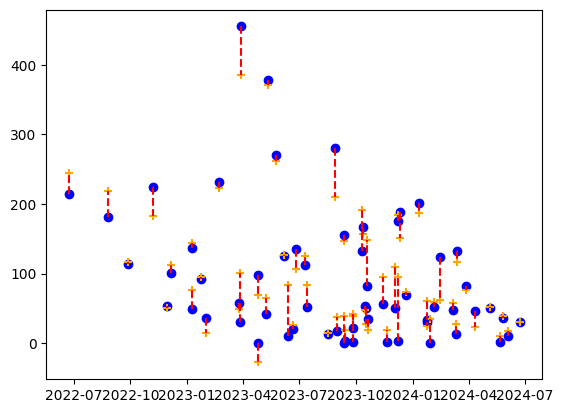

In [167]:
y_pred = hist_grad_boost_reg.predict(X_val)
x_coords = X_val["PURCHASE_DATE"][0::250]
y_coords_true = list(y_val[0::250])
y_coords_pred = list(y_pred[0::250])
plt.scatter(x=x_coords, y=y_coords_true, c="blue")
plt.scatter(x=x_coords, y=y_coords_pred, c="orange", marker="+")
for i, x in enumerate(x_coords):
    if not pd.notna(x):
        continue
    plt.plot([x, x], [y_coords_true[i], y_coords_pred[i]], c="red", linestyle="--")
plt.show()

In [75]:
import sklearn
sklearn.set_config(
   assume_finite=True,  # disable validation
)


def perm_feat_importance_selector(X, y) -> np.array:
    return importance.importances_mean


rng = np.random.RandomState(42)
selector = SelectKBest(perm_feat_importance_selector, k=50)
selector.set_output(transform="pandas")

hist_grad_boost_reg = Pipeline([
    ("selector", selector),
    ("preprocessor", create_preprocessor()),
    ("regressor", HistGradientBoostingRegressor(max_iter=400, learning_rate=0.15, max_leaf_nodes=90, random_state=rng)),
])

cross_validate_model(hist_grad_boost_reg)

RMSE Scores: [39.94166869 40.9833168  39.24079453 46.20303789 40.66379148]
RMSE Mean: 41.40652187839211
RMSE Std: 2.4727914041379964


### LightGBM

In [168]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV


rng = np.random.RandomState(42)

param_grid = {
    'regressor__boosting_type': ['dart'],
    'regressor__learning_rate': [0.35],
    # 'regressor__learning_rate': [0.1],
    # 'regressor__n_estimators': [10000],
    'regressor__n_estimators': [2000],
    'regressor__num_leaves': [100],
    # 'regressor__max_depth': [18, 19, 20],
    'regressor__max_depth': [20],
    'regressor__min_child_samples': [20],
    'regressor__min_child_weight': [1e-2],
    # 'regressor__min_split_gain': [0.0, 0.01, 0.1],
    'regressor__subsample': [1.0],
    'regressor__subsample_freq': [177],
}

lgbm_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("regressor", lgb.LGBMRegressor(random_state=rng, n_estimators=1000, n_jobs=28)),
])

grid_search = GridSearchCV(
    estimator=lgbm_reg,
    param_grid=param_grid,
    # scoring='neg_mean_squared_error',
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=4
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

# cross_validate_model(lgbm_reg)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9024
[LightGBM] [Info] Number of data points in the train set: 63264, number of used features: 249
[LightGBM] [Info] Start training from score 88.209709
[CV 1/5] END regressor__boosting_type=dart, regressor__learning_rate=0.35, regressor__max_depth=20, regressor__min_child_samples=20, regressor__min_child_weight=0.01, regressor__n_estimators=2000, regressor__num_leaves=100, regressor__subsample=1.0, regressor__subsample_freq=177;, score=-37.131 total time=  41.5s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9205
[LightGBM] [Info] Number of data points in the train set: 63264, number of used featur

In [181]:
import lightgbm as lgb

rng = np.random.RandomState(42)

lgbm_regressor = lgb.LGBMRegressor(
        random_state=rng,
        boosting_type="dart",
        n_estimators=5000,
        learning_rate=0.35,
        num_leaves=100,
        max_depth=20,
        min_child_samples=20,
        min_child_weight=1e-2,
        subsample=1.0,
        subsample_freq=177
        )

lgbm_reg = Pipeline([
    ("preprocessor", create_preprocessor()),
    ("regressor", lgbm_regressor),
])

importance = inspect_model_feature_importance(lgbm_reg)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6459
[LightGBM] [Info] Number of data points in the train set: 63264, number of used features: 115
[LightGBM] [Info] Start training from score 88.209709
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8994
[LightGBM] [Info] Number of data points in the train set: 63264, number of used features: 250
[LightGBM] [Info] Start training from score 88.301372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6589
[LightGBM] [Info] Number of data points in the train

/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11

PURCHASE_DATE                                                0.778 +/- 0.010
SCALED_CURRENT_VALUE                                         0.293 +/- 0.004
AT_LOCATION_SINCE                                            0.270 +/- 0.004
SCALED_INVENTURAL_VALUE                                      0.188 +/- 0.004
PURCHASE_BOOKING_DATE                                        0.124 +/- 0.002
SCALED_TOTAL_SALE_PRICE                                      0.074 +/- 0.001
DIFF__PURCHASE_DATE__PURCHASE_BOOKING_DATE                   0.071 +/- 0.001
MILAGE_SALE                                                  0.055 +/- 0.002
COMMISSION_TYPE_NAME                                         0.051 +/- 0.003
COMMISSION_TYPE                                              0.051 +/- 0.003
PURCHASE_DATE__YEAR                                          0.047 +/- 0.002
ENGINE_TYPE                                                  0.047 +/- 0.001
SCALED_TOTAL_SALES_PRICE_BASIS                               0.037 +/- 0.001

In [182]:
import sklearn

sklearn.set_config(
    assume_finite=True,  # disable validation
)


def perm_feat_importance_selector(X, y) -> np.array:
    return importance.importances_mean


rng = np.random.RandomState(42)
selector = SelectKBest(perm_feat_importance_selector, k=50)
selector.set_output(transform="pandas")

lgbm_reg = Pipeline([
    ("selector", selector),
    ("preprocessor", create_preprocessor()),
    ("regressor", lgbm_regressor),
])

cross_validate_model(lgbm_reg)

/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.11

RMSE Scores: [37.19337141 37.64987749 36.39781151 43.8156511  37.29865113]
RMSE Mean: 38.47107252887122
RMSE Std: 2.7034934702033557


## Select final model
Select the final model based on the cross validation scores of each one.

In [183]:
final_model = hist_grad_boost_reg

## Evaluate final model on the test set
Get an approximation for the generalization error of the final model.

In [184]:
test_model(final_model)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6578
[LightGBM] [Info] Number of data points in the train set: 79080, number of used features: 115
[LightGBM] [Info] Start training from score 88.335015
RMSE: 67.52080978200644


# Predicting new data

## Train final model on the full data set

In [186]:
df_prep = prepare_data_frame(df, is_test=False, drop_rows=True)
X, y = split_data_frame(df_prep)
final_model.fit(X, y);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 98821, number of used features: 116
[LightGBM] [Info] Start training from score 88.211382


## Load and prepare test data frame

In [187]:
df_new = pd.read_excel("data/Vehicles_export_prices_scaled_stud_test_eng.xlsx")

In [188]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42425 entries, 0 to 42424
Columns: 106 entries, RPAKREP_VEHICLE_HKEY to SCALED_TOTAL_SALE_PRICE
dtypes: datetime64[ns](5), float64(15), int64(26), object(60)
memory usage: 34.3+ MB


In [189]:
df_new_prep = prepare_data_frame(df_new, is_test=True, drop_rows=False)

In [190]:
df_new_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42425 entries, 0 to 42424
Columns: 125 entries, COMPANY to DIFF__PURCHASE_BOOKING_DATE__CONSTRUCTION_DATE
dtypes: datetime64[ns](6), float64(52), string(67)
memory usage: 40.5 MB


## Predict new values

In [191]:
X_new, _ = split_data_frame(df_new_prep)
y_new = final_model.predict(X_new)

## Inspect predicted values

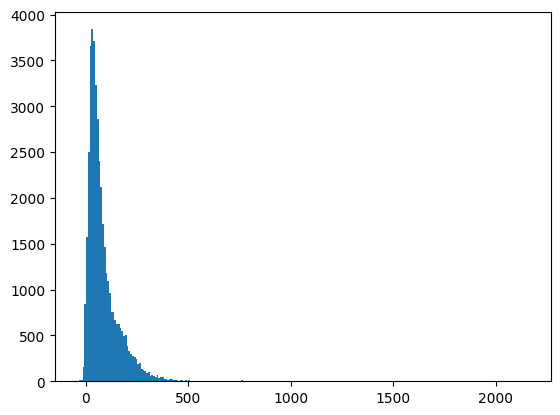

In [192]:
plt.hist(y_new, bins=256)
plt.show()

## Save predicted values

In [85]:
def save_to_xlsx(features: pd.DataFrame, predictions: np.array, filename: str):
    output_dir = "predictions"
    os.makedirs(output_dir, exist_ok=True)
    
    df_output = features.copy()
    df_output["LAID_UP_TIME"] = predictions
    df_output[["CHASSIS_NUMBER", "LAID_UP_TIME"]].to_excel(f"{output_dir}/{filename}", index = False)

In [193]:
save_to_xlsx(X_new, y_new, "teamA-model3.xlsx")